<a href="https://colab.research.google.com/github/aditya-saurabh/generative-adversial-network/blob/master/unconditional_gan_mnist_hand_written.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Conv2D, Flatten, Input, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, LeakyReLU, Reshape, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


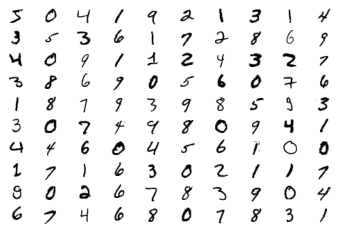

In [4]:
for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(train_x[i], cmap='gray_r', )
plt.show()

In [0]:
def discriminator(input_shape=(28,28,1)):
  model = keras.Sequential()
  

  #downsample
  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #Flatten
  model.add(Flatten())
  model.add(Dropout(0.4))

  #Dense layer
  model.add(Dense(128, activation='tanh'))
  model.add(Dropout(0.4))

  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [0]:
def generator(latent_dim):
  model = keras.Sequential()
  n = 7*7*128

  model.add(Dense(n, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))

  #Rehsape to 7 * 7 * 128
  model.add(Reshape((7, 7, 128)))
  
  #upsampling
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #upsampling
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #generate
  model.add(Conv2D(1, (5,5), strides=(1,1), padding='same', activation='tanh'))
  
  return model

In [0]:
def gan(gen, dis):

  #making discriminator training to false 
  dis.trainable = False

  model = keras.Sequential()

  # add generator
  model.add(gen)

  # add the discriminator
  model.add(dis)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


In [0]:
def load_real_samples():
  (trainX, _), (_,_) = keras.datasets.mnist.load_data()

  X = np.expand_dims(trainX, axis=-1)

  #convert from int to float
  X = X.astype('float')

  #normalizing the data
  X = (X-127.5)/127.5

  return X

In [0]:
def generate_real_samples(dataset, n_samples):

  ix = np.random.randint(0, dataset.shape[0], n_samples)

  X = dataset[ix]

  y = np.ones((n_samples, 1))

  return X, y

In [0]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [0]:
def generate_fake_samples(gen, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)

  X = gen.predict(x_input)
  y = np.zeros((n_samples, 1))

  return X, y

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
dis = discriminator()
# create the generator
gen = generator(latent_dim)
# create the gan
gan_model = gan(gen, dis)
# load image data
dataset = load_real_samples()


In [25]:
# train model
train(gen, dis, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>20, 150/468, d1=0.702, d2=0.624 g=0.865
>20, 151/468, d1=0.644, d2=0.640 g=0.860
>20, 152/468, d1=0.715, d2=0.656 g=0.820
>20, 153/468, d1=0.689, d2=0.698 g=0.793
>20, 154/468, d1=0.626, d2=0.711 g=0.819
>20, 155/468, d1=0.647, d2=0.711 g=0.828
>20, 156/468, d1=0.674, d2=0.651 g=0.793
>20, 157/468, d1=0.715, d2=0.681 g=0.847
>20, 158/468, d1=0.725, d2=0.688 g=0.829
>20, 159/468, d1=0.641, d2=0.645 g=0.825
>20, 160/468, d1=0.669, d2=0.737 g=0.788
>20, 161/468, d1=0.650, d2=0.665 g=0.811
>20, 162/468, d1=0.697, d2=0.656 g=0.840
>20, 163/468, d1=0.672, d2=0.680 g=0.808
>20, 164/468, d1=0.643, d2=0.689 g=0.824
>20, 165/468, d1=0.671, d2=0.654 g=0.818
>20, 166/468, d1=0.684, d2=0.718 g=0.822
>20, 167/468, d1=0.666, d2=0.686 g=0.822
>20, 168/468, d1=0.652, d2=0.642 g=0.819
>20, 169/468, d1=0.675, d2=0.638 g=0.854
>20, 170/468, d1=0.683, d2=0.627 g=0.845
>20, 171/468, d1=0.739, d2=0.657 g=0.840
>20, 172/468, d1=0.716, d2=0.691 g=0.791
>20, 1

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


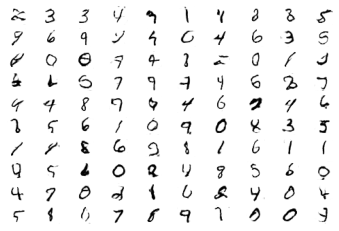

In [27]:
# example of loading the generator model and generating images
from keras.models import load_model

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)

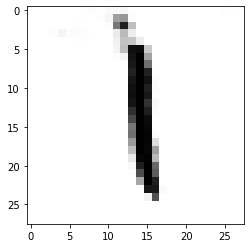

In [32]:
plt.imshow(X[5, :, :, 0], cmap='gray_r')